In [1]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

2022-11-21 12:18:31.249703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 12:18:31.933125: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 12:18:34.125307: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-21 12:18:34.125461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
dataset = pd.read_csv("../Datasets/housing.csv")
dataset = dataset.dropna(axis=0)
dataset = dataset.drop('ocean_proximity',axis=1)
dataset = shuffle(dataset)
x_test = dataset.iloc[:2000,:]
x_train = dataset.iloc[2000:,:]
y_train = x_train.pop("median_house_value")
y_test = x_test.pop("median_house_value")

In [3]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = np.expand_dims(y_train,axis=1)
y_test = np.expand_dims(y_test,axis=1)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [4]:
def California_Housing():
  model = Sequential()
  model.add(Dense(20, activation='relu', input_shape=(x_train[0].shape)))
  model.add(Dense(15, activation='relu')) 
  model.add(Dense(1, activation=keras.activations.softsign))
  model.compile(optimizer='SGD', loss=keras.losses.MAE, metrics=['mae'])
  return model

In [5]:
epochs = 2500
batch_size = 256

In [6]:
model_const = California_Housing()
# K.set_value(model_const.optimizer.learning_rate, 0.01)
history = model_const.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test))

2022-11-21 12:18:38.683372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-21 12:18:38.683842: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-21 12:18:38.683884: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-CN1DC8GL): /proc/driver/nvidia/version does not exist
2022-11-21 12:18:38.685017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
lrs = [] # to store learning rates
K1 = 0.
model_adapt = California_Housing()
func = K.function([model_adapt.layers[0].input], [model_adapt.layers[-2].output]) # to get the values of activations of second last layer
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
      
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      if activ > Kz:
          Kz = activ
    K1 = (1/batch_size)*(Kz)
    lr = 1 / K1*0.01
    lrs.append(lr)
    return lr

In [8]:
lr_scheduler = LearningRateScheduler(lr_schedule)
history_lalr = model_adapt.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test), callbacks=[lr_scheduler])

302
1655


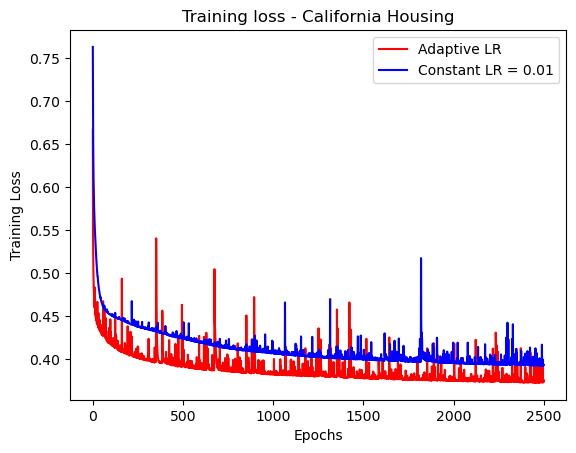

In [24]:
loss_adaptive = history_lalr.history['loss']
loss_constant = history.history['loss']
# to print value just less than threshold
# for x in loss_adaptive:
#     if(x<0.398):
#         print(loss_adaptive.index(x))
#         break
# for x in loss_constant:
#     if(x<0.398):
#         print(loss_constant.index(x))
#         break
epochs = range(len(loss_adaptive))

plt.plot(epochs, loss_adaptive, 'r', label='Adaptive LR')
plt.plot(epochs, loss_constant, 'b',label="Constant LR = 0.01")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
# plt.plot(epochs, history_lalr, 'b', label='LALR')
plt.title('Training loss - California Housing')
plt.legend()

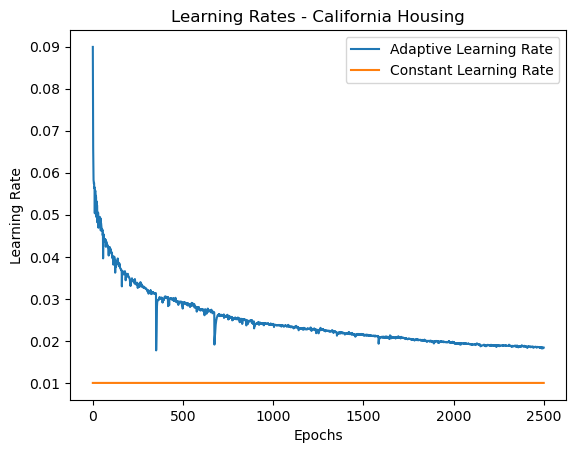

In [10]:
plt.title('Learning Rates - California Housing')
plt.plot(epochs, lrs, label='Adaptive Learning Rate')
plt.plot(epochs, [0.01]*len(epochs), label ='Constant Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()